In [3]:
#Import functions------------------------------------------------------------------------------------------------------
from my_functions import*

#Open ROOT file with uproot--------------------------------------------------------------------------------------------
file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/Muon_trees.root") 

#Get trees-------------------------------------------------------------------------------------------------------------
MuonTree_ZeroBias=file["MuonTree_ZeroBias;1"]
MuonTree_Zmumu=file["MuonTree_Zmumu;1"]

#Get data from trees---------------------------------------------------------------------------------------------------
#Z -> mu mu
Zmumu_pt  = MuonTree_Zmumu["muon_pt"].array()
Zmumu_eta = MuonTree_Zmumu["muon_eta"].array()
Zmumu_phi = MuonTree_Zmumu["muon_phi"].array()
#Zero Bias
ZeroBias_pt  = MuonTree_ZeroBias["muon_pt"].array()
ZeroBias_eta = MuonTree_ZeroBias["muon_eta"].array()
ZeroBias_phi = MuonTree_ZeroBias["muon_phi"].array()
#Pre-select data-------------------------------------------------------------------------------------------------------
#Chose event range
#Z -> mu mu range
nmin1=0
nmax1=10000
#Zero Bias range
nmin2=0
nmax2=200000
#Select quality 0 Z->mumu
Zmumu_pt=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_pt"].array(),0)[nmin1:nmax1]
Zmumu_eta=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_eta"].array(),0)[nmin1:nmax1]
Zmumu_phi=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_phi"].array(),0)[nmin1:nmax1]
#Select the Z peak pairs
Zmumu_pt, Zmumu_eta, Zmumu_phi= get_all_Z_peak_pairs(Zmumu_pt,Zmumu_eta,Zmumu_phi)

#Select ZeroBias
ZeroBias_pt=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_pt"].array())[nmin2:nmax2]
ZeroBias_eta=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_eta"].array())[nmin2:nmax2]
ZeroBias_phi=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_phi"].array())[nmin2:nmax2]

 25%|██▌       | 2508/10000 [00:04<00:13, 559.35it/s]


KeyboardInterrupt: 

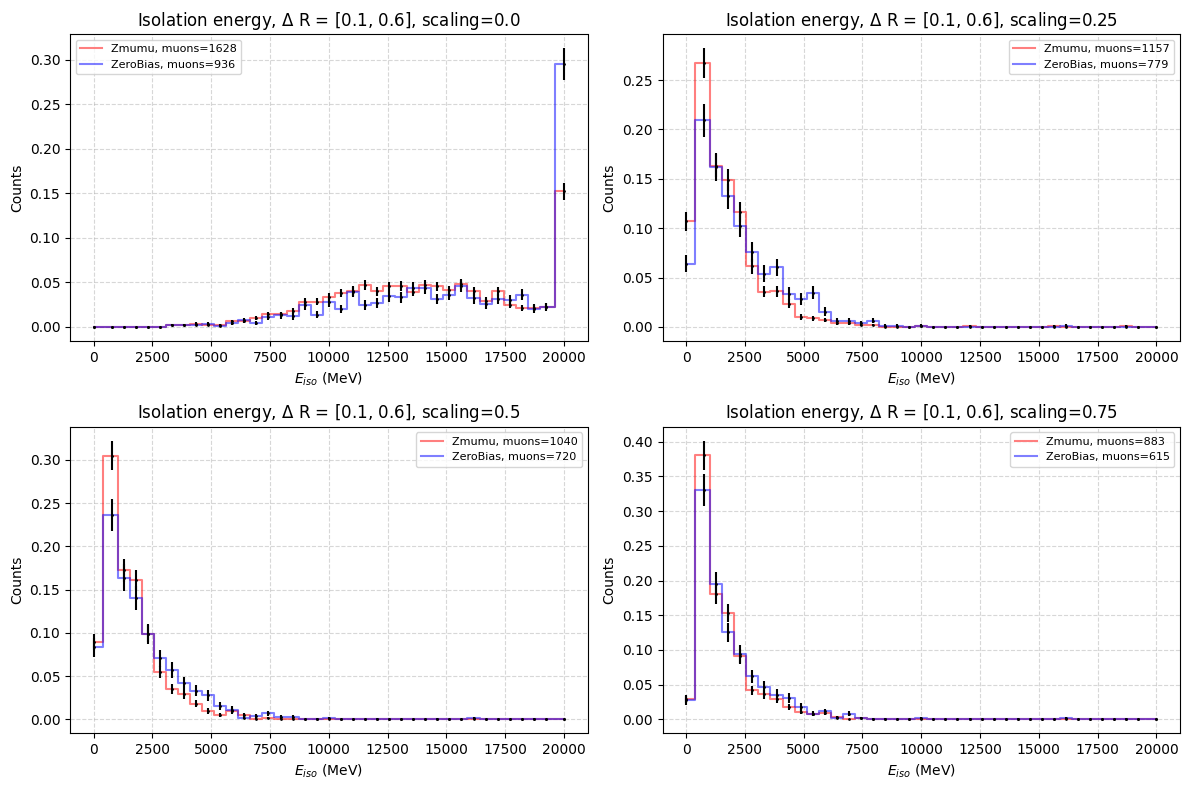

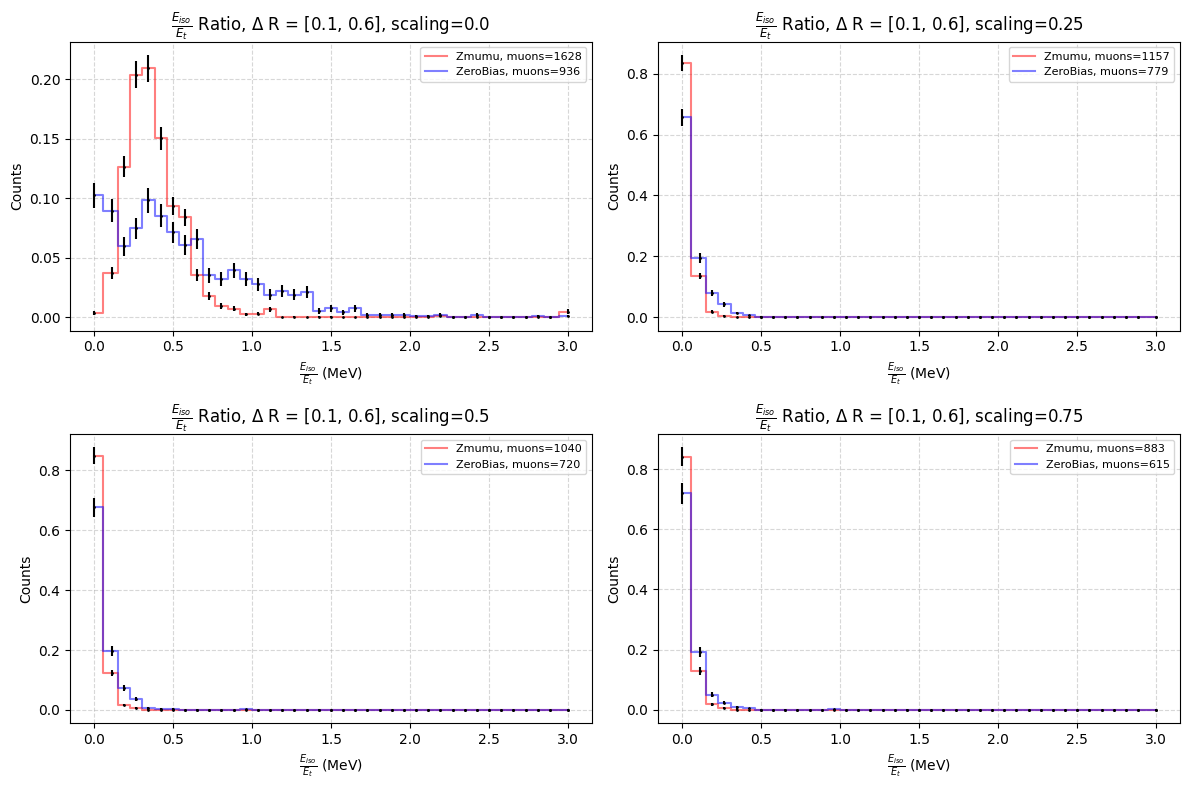

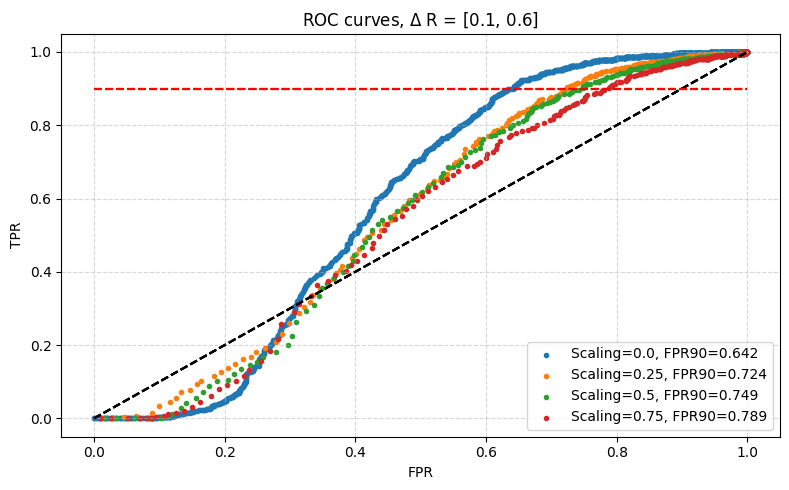

In [2]:

fig2, axis2 = plt.subplots(2, 2, figsize=(12, 8))
fig3, axis3 = plt.subplots(2, 2, figsize=(12, 8))
fig4, axis4 = plt.subplots(1, 1, figsize=(8, 5))
#Set delta R
dr_mins=[0.10, 0.10, 0.10, 0.10]
dr_maxs=[0.60, 0.60, 0.60, 0.60]
scalings=[0.0, 0.25, 0.5, 0.75]
#Loop over all upper_cuts values
for i in range(len(dr_mins)):
    dr_min=dr_mins[i]
    dr_max=dr_maxs[i]

    res1=muon_isolation_all_events(MuonTree_Zmumu, Zmumu_eta, Zmumu_phi, dr_min, dr_max, event_range=[nmin1, nmax1], scaling=scalings[i])
    res2=muon_isolation_all_events(MuonTree_ZeroBias, ZeroBias_eta, ZeroBias_phi, dr_min, dr_max, event_range=[nmin2, nmax2], scaling=scalings[i])

    bins=np.linspace(0,20*10**3,40)
    row, col = divmod(i, 2)
    ax = axis2[row][col]

    aux=ak.flatten(res1)
    l1=len(aux[~np.isnan(aux)])
    aux=ak.flatten(res2)
    l2=len(aux[~np.isnan(aux)])

    coolplot(
        [res1, res2],
        bins=bins,
        labels=[f"Zmumu, muons={l1}", f"ZeroBias, muons={l2}"],
        x_label=r"$E_{iso}$ (MeV)",
        y_label="Counts",
        title=fr"Isolation energy, $\Delta$ R = [{dr_min}, {dr_max}], scaling={scalings[i]}",
        ax=ax)
    
    fig2.tight_layout()
    ratio1=ak.flatten(res1)/ak.flatten(Zmumu_pt)
    ratio1=ratio1[~np.isnan(ratio1)]
    l1=len(ratio1)

    ratio2=ak.flatten(res2)/ak.flatten(ZeroBias_pt)
    ratio2=ratio2[~np.isnan(ratio2)]
    l2=len(ratio2)

    bins=np.linspace(0,3.0,40)
    row, col = divmod(i, 2)
    ax = axis3[row][col]
    
    coolplot(
    [ratio1, ratio2],
    bins=bins,
    labels=[f"Zmumu, muons={l1}", f"ZeroBias, muons={l2}"],
    x_label=r"$\frac{E_{iso}}{E_{t}}$ (MeV)",
    y_label="Counts",
    title=fr"$\frac{{E_{{iso}}}}{{E_{{t}}}}$ Ratio, $\Delta$ R = [{dr_min}, {dr_max}], scaling={scalings[i]}",
    ax=ax)

    fig3.tight_layout()

    bins=np.linspace(0,2,2000)

    data1=ratio1
    data1=data1[~np.isnan(data1)]
    data2=ratio2
    data2=data2[~np.isnan(data2)]
    Zmumu_counts, _ = np.histogram(data1, bins)
    ZeroBias_counts, _ = np.histogram(data2, bins)
    #Compute the cumulative sum of the counts (like integrating the histogram to the left)
    Zmumu_cumulative_counts = np.cumsum(Zmumu_counts)
    ZeroBias_cumulative_counts = np.cumsum(ZeroBias_counts)
    # Normalize to total events
    TPR = Zmumu_cumulative_counts / np.sum(Zmumu_counts)
    FPR = ZeroBias_cumulative_counts / np.sum(ZeroBias_counts)

    FPR90=min(FPR[TPR >= 0.9])
    ax=axis4
    plt.scatter(FPR, TPR, marker='.', label=fr'Scaling={scalings[i]}, FPR90={np.round(FPR90,3)}')
    plt.plot([0,1],[0,1], color='black', linestyle='--')
    plt.plot([0,1],[0.9,0.9],color='r', linestyle='--')
    plt.grid(alpha=0.5, linestyle='--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.title(rf"ROC curves, $\Delta$ R = [{dr_min}, {dr_max}]")
    plt.tight_layout()

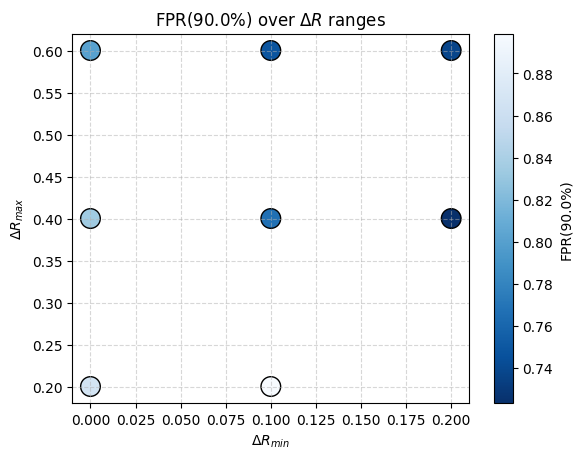

Top 5 lowest FPR(90%):
1. ΔR = [0.2, 0.4] → FPR = 0.7232558139534884
2. ΔR = [0.2, 0.6] → FPR = 0.7369942196531792
3. ΔR = [0.1, 0.6] → FPR = 0.7486111111111111
4. ΔR = [0.1, 0.4] → FPR = 0.7665995975855131
5. ΔR = [0.0, 0.6] → FPR = 0.8010899182561307


In [3]:
##################################################################################################################################33
points=3
iterations=1
next_dr_mins=np.linspace(0,0.20,points)
next_dr_maxs=np.linspace(0.20,0.6,points)

min_range=[min(next_dr_mins), max(next_dr_mins)]
max_range=[min(next_dr_maxs), max(next_dr_maxs)]

FPR_effs, dr_mins, dr_maxs= ROC_FPR_2D_plot(MuonTree_Zmumu, MuonTree_ZeroBias, Zmumu_pt, Zmumu_eta, Zmumu_phi, ZeroBias_pt, ZeroBias_eta,
                 ZeroBias_phi, [nmin1,nmax1], [nmin2, nmax2], min_range, max_range, points, bins=np.linspace(0,2,1000), scaling=0.5)

#Get flat position the first 5 indices of the sorted array
flat_indices = np.argsort(FPR_effs, axis=None)[:5] 
#Arrange them into 2D coordinates
positions = np.unravel_index(flat_indices, FPR_effs.shape) 
#Create list of respective pairs 
best_coords = list(zip(positions[0], positions[1]))
#Print and prepare next iteration
next_dr_mins=[]
next_dr_maxs=[]
print("Top 5 lowest FPR(90%):")
for i, (row, col) in enumerate(best_coords):
    print(fr"{i+1}. ΔR = [{dr_mins[row]}, {dr_maxs[col]}] → FPR = {FPR_effs[row, col]}")
    next_dr_mins.append(dr_mins[row])
    next_dr_maxs.append(dr_maxs[col])

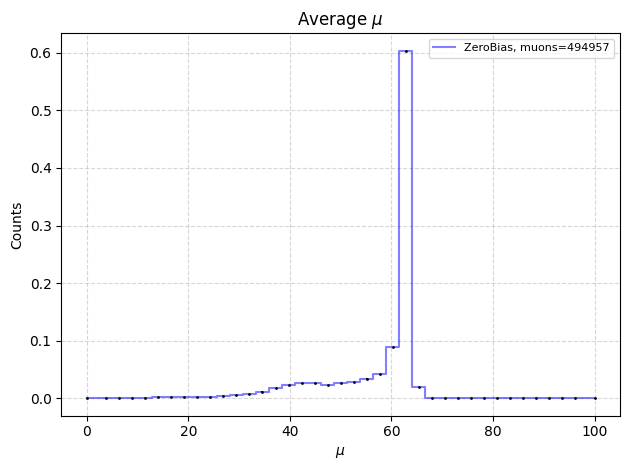